In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install bert-for-tf2

     |████████████████████████████████| 40kB 1.9MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.6-cp36-none-any.whl size=30318 sha256=9294be3f997e72331c45189223772acdd9ebb39711b0522e01c0937b6b6631ff
  Stored in directory: /root/.cache/pip/wheels/07/a0/b4/75b0601ebaa41e517a797fe9cea119c789664c8408f8a74ae9
  Created wheel for py-params: filename=py_params-0.9.7-cp36-none-any.whl size=7304 sha256=7e116c0e1da615c5c1261edc2d9d18e7f958c1ffec0dc08d757ee7098158fcfd
  Stored in directory: /root/.cache/pip/wheels/67/f5/19/b461849a50aefdf4bab47c4756596e82ee2118b8278e5a1980
  Created wheel for params-flow: filename=params_flow-0.8.2-cp36-none-any.whl size=19475 sha256=29646059a438e070b3c1808a3fa13975217e47f59359e37ffe152a4646187367
  Stored in directory: /root/.cache/pip/wheels/08/c8/7f/81c86b9ff2b86e2c477e3914175be03e679e596067dc630c06
Successfully built bert-for-tf2 py-params params-flow


In [4]:
!pip install tf-models-official

     |████████████████████████████████| 849kB 3.1MB/s 
     |████████████████████████████████| 1.1MB 16.8MB/s 
     |████████████████████████████████| 174kB 23.6MB/s 
     |████████████████████████████████| 358kB 17.1MB/s 
     |████████████████████████████████| 36.7MB 1.3MB/s 
     |████████████████████████████████| 102kB 12.6MB/s 
  Created wheel for py-cpuinfo: filename=py_cpuinfo-7.0.0-cp36-none-any.whl size=20071 sha256=79fb382707c17cdc4e4245badfcfdba988fb6f65ffb2604ba85bbf9d83fcd68f
  Stored in directory: /root/.cache/pip/wheels/f1/93/7b/127daf0c3a5a49feb2fecd468d508067c733fba5192f726ad1
Successfully built py-cpuinfo


In [5]:
!pip install transformers

     |████████████████████████████████| 1.0MB 2.9MB/s 
     |████████████████████████████████| 3.0MB 18.4MB/s 
     |████████████████████████████████| 890kB 34.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=9d4162e6b6ee6047e7f6b96d7b68ffc7bbbebf2d621acfcab6a1871561683225
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [6]:
!pip install keras-radam

  Created wheel for keras-radam: filename=keras_radam-0.15.0-cp36-none-any.whl size=14686 sha256=d89a5571412ad8c7d35db6e6871cd3f210a85b519eeabb725e538110fc74483a
  Stored in directory: /root/.cache/pip/wheels/79/a0/c0/670b0a118e8f078539fafec7bd02eba0af921f745660c7f83f
Successfully built keras-radam


In [7]:
#!/usr/bin/env python
# coding: utf-8

# In[23]:


import os
import math
import datetime

from tqdm import tqdm

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer
# from transformers import AdamW
from keras_radam import RAdam

# from tensorflow.keras.optimizers import Adam
# from adamw_optimizer import AdamW

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report

# get_ipython().run_line_magic('matplotlib', 'inline')
# get_ipython().run_line_magic('config', "InlineBackend.figure_format='retina'")

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [12]:
from tensorflow.python.framework.test_util import is_gpu_available as tf
if tf()==True:
  device='/gpu:0'
else:
  device='/cpu:0'

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


In [8]:
# text processing libraries
import re
import string
import nltk
from nltk.corpus import stopwords

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text


def text_preprocessing(text):
    """
    Cleaning and parsing the text.

    """
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    nopunc = clean_text(text)
    tokenized_text = tokenizer.tokenize(nopunc)
    #remove_stopwords = [w for w in tokenized_text if w not in stopwords.words('english')]
    combined_text = ' '.join(tokenized_text)
    return combined_text

2331it [00:01, 2002.42it/s]
583it [00:00, 2070.90it/s]


max seq_len 43


AttributeError: ignored

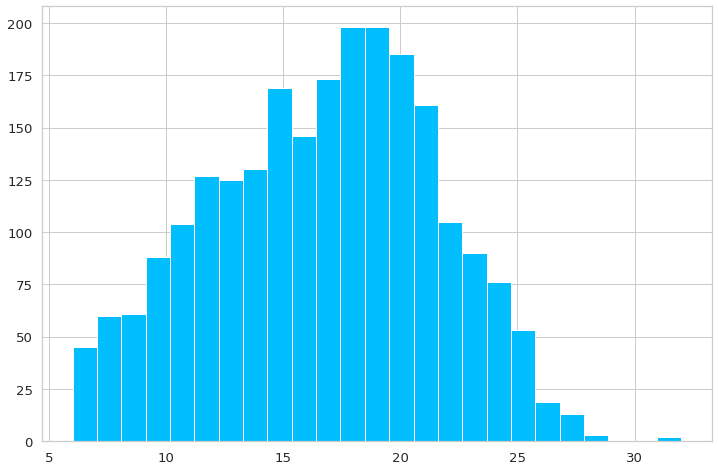

In [13]:
train_df = pd.read_csv('drive/My Drive/StanceDataset/train.csv', lineterminator='\r', encoding = 'latin-1')


# In[3]:


test_df = pd.read_csv('drive/My Drive/StanceDataset/test.csv', lineterminator='\r', encoding = 'latin-1')


# In[4]:


# train_df.head()


# # In[31]:


# test_df.info()


# # In[29]:


# train_df.info()


# # In[26]:


# train_df.groupby(by = ['Target', 'Stance'])['Tweet'].count()#.reset_index(drop=True)


# # In[32]:


# test_df.groupby(by = ['Target', 'Stance'])['Tweet'].count()#.reset_index(drop=True)


# # In[8]:


# train_df.groupby(by = ['Target', 'Stance'])['Stance'].count().unstack().plot.barh(figsize = (9,5), width = 0.8)


# # In[35]:


# test_df.groupby(by = ['Target', 'Stance'])['Stance'].count().unstack().plot.barh(figsize = (9,6), width = 0.8)


# In[33]:


test_df['Stance'].value_counts()


# In[27]:


train_df['Stance'].value_counts()


# In[5]:


# train_df['Stance'].value_counts().plot.bar(rot = 0, width = 0.3)
# plt.xlabel('Stance')
# plt.ylabel('Count')


# # In[37]:


# test_df['Stance'].value_counts().plot.bar(rot = 0, width = 0.3)
# plt.xlabel('Stance')
# plt.ylabel('Count')


# In[5]:

train_df['Tweet'] = train_df['Tweet'].apply(str).apply(lambda x: text_preprocessing(x))
X = train_df[['Tweet', 'Stance']]
y = train_df['Stance']


# In[6]:


from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y, shuffle = True)


# In[7]:


train_text = X_train['Tweet']
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 25)


# In[8]:


X_train


# In[9]:


# os.makedirs("model", exist_ok=True)


# In[10]:


bert_model_name="uncased_L-12_H-768_A-12"

bert_ckpt_dir = os.path.join("drive/My Drive/model/", bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")


# In[11]:


class IntentDetectionData:
  DATA_COLUMN = "Tweet"
  LABEL_COLUMN = "Stance"

  def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len=32):
    self.tokenizer = tokenizer
    self.max_seq_len = 0
    self.classes = classes
    
    ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare, [train, test])

    print("max seq_len", self.max_seq_len)
    self.max_seq_len = min(self.max_seq_len, max_seq_len)
    self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])

  def _prepare(self, df):
    x, y = [], []
    
    for _, row in tqdm(df.iterrows()):
      text, label = row[IntentDetectionData.DATA_COLUMN], row[IntentDetectionData.LABEL_COLUMN]
      tokens = self.tokenizer.tokenize(text)
      tokens = ["[CLS]"] + tokens + ["[SEP]"]
      token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
      self.max_seq_len = max(self.max_seq_len, len(token_ids))
      x.append(token_ids)
      y.append(self.classes.index(label))

    return np.array(x), np.array(y)

  def _pad(self, ids):
    x = []
    for input_ids in ids:
      input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
      input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
      x.append(np.array(input_ids))
    return np.array(x)


# In[12]:


tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))


# In[13]:


# tokenizer.tokenize("@DrAliceRoberts was awarded Humanist of the")


# In[14]:


# tokens = tokenizer.tokenize("I can't wait to visit Bulgaria again!")
# tokenizer.convert_tokens_to_ids(tokens)


# In[15]:


def create_model(max_seq_len, bert_ckpt_file):

  with tf.io.gfile.GFile(bert_config_file, "r") as reader:
      bc = StockBertConfig.from_json_string(reader.read())
      bert_params = map_stock_config_to_params(bc)
      bert_params.adapter_size = None
      bert = BertModelLayer.from_params(bert_params, name="bert")
      bert.apply_adapter_freeze()
        
  input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
  bert_output = bert(input_ids)

  print("bert shape", bert_output.shape)

  # cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
  # cls_out = keras.layers.Dropout(0.5)(cls_out)
  # logits = keras.layers.Dense(units=500, activation="relu")(cls_out)
  # logits = keras.layers.Dropout(0.5)(logits)
  # logits = keras.layers.Dense(units=len(classes), activation="softmax")(logits)

  cls_out = keras.layers.Flatten()(bert_output)
  
  cls_out = keras.layers.Dense(512, activation="relu")(cls_out)
  cls_out = keras.layers.Dropout(0.5)(cls_out)
  logits = keras.layers.Dense(units=512, activation="relu")(cls_out)
  logits = keras.layers.Dropout(0.5)(logits)
  logits = keras.layers.Dense(256, activation='relu')(logits)
  logits = keras.layers.Dense(units=len(classes), activation="softmax")(logits)

  model = keras.Model(inputs=input_ids, outputs=logits)
  model.build(input_shape=(None, max_seq_len))

  load_stock_weights(bert, bert_ckpt_file)
        
  return model


# In[16]:


classes = X_train['Stance'].unique().tolist()

data = IntentDetectionData(X_train, X_val, tokenizer, classes, max_seq_len=32)


# In[17]:


data.train_x.shape


# In[18]:


data.train_x[0]


# In[19]:


data.train_y[0]


# In[20]:


data.max_seq_len


# In[21]:


model = create_model(data.max_seq_len, bert_ckpt_file)

model.summary()

# define the optimizer
# from tensorflow_addons.optimizers import AdamW
# optimizer = AdamW(weight_decay=0.001, learning_rate=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-6)


model.compile(
  optimizer=tf.optimizers.Adam(learning_rate = 2e-5,  epsilon=1e-08),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)


# In[60]:


os.makedirs("log/stance_detection/", exist_ok=True)


# In[ ]:

# os.mkdir('log/stance_detection/')

# log_dir = "log\\stance_detection\\" + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
# tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)

history = model.fit(
  x=data.train_x, 
  y=data.train_y,
  # validation_split=0.1,
  batch_size=32,
  shuffle=True,
  epochs=10,
  validation_data = (data.test_x, data.test_y)
  # callbacks=[tensorboard_callback]
)

_, train_acc = model.evaluate(data.train_x, data.train_y)
_, test_acc = model.evaluate(data.test_x, data.test_y)

# y_pred = model.predict(data.test_x)


# from sklearn.metrics import classification_report

print("train acc", train_acc)
print("test acc", test_acc)

# print(classification_report(data.test_y, y_pred))

model.save('stance_model.h5')

In [ ]:
test_df

In [53]:
classes = X_train['Stance'].unique().tolist()
test_df['Tweet'] = test_df['Tweet'].apply(str).apply(lambda x: text_preprocessing(x))

In [57]:
test_data = test_df['Tweet']

In [60]:
test_data = IntentDetectionData(test_df, test_df,  tokenizer, classes, max_seq_len=32)

1956it [00:00, 2229.79it/s]
1956it [00:00, 2233.74it/s]

max seq_len 74


In [106]:
y_pred = model.predict(test_data.train_x)

In [107]:
y = []
for result in y_pred:
  y.append(np.argmax(result))

In [108]:
label_dict = { 1 : 'NONE',
              0 : 'AGAINST',
              2 : 'FAVOR'    
}

In [109]:
y_pred =  [label_dict[k] for k in y]

In [117]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt    

cm = confusion_matrix(test_df['Stance'], y_pred)

cm = cm.astype('int')

labels = ['AGAINST', 'NONE', 'FAVOR']

from sklearn.metrics import classification_report

print(classification_report(test_df['Stance'], y_pred, target_names=labels))

              precision    recall  f1-score   support

     AGAINST       0.68      0.58      0.63      1014
        NONE       0.49      0.39      0.43       452
       FAVOR       0.39      0.58      0.47       490

    accuracy                           0.54      1956
   macro avg       0.52      0.52      0.51      1956
weighted avg       0.56      0.54      0.54      1956



In [65]:
model.evaluate(test_data.train_x, test_data.train_y)

62/62 [==============================] - 4s 61ms/step - loss: 1.0130 - acc: 0.5363


[1.012978196144104, 0.5362985730171204]

In [11]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize    
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn't guaranteed
gpu = GPUs

def printm():
  process = psutil.Process(os.getpid())
  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " I Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print('GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB'.format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

printm()

Gen RAM Free: 12.7 GB  I Proc size: 398.7 MB


AttributeError: ignored